In [1]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.tree import DecisionTreeRegressor,export_graphviz
import sklearn.model_selection as sk
from sklearn.ensemble import RandomForestRegressor
import pydotplus

'''Here we assess two machine learning algorithms to predict the energy star score. 
    The energy star score is a number between 1 and 100 and indicates your building's performance
    relative to other buildings of the same property type. 




    First, we load the datasets.'''



df=pd.read_csv("Chicago_Energy_Benchmarking_-_2014_Data_Reported_in_2015.csv")

gf=pd.read_csv("Chicago_Energy_Benchmarking_-_2015_Data_Reported_in_2016.csv")
hf=pd.read_csv("Chicago_Energy_Benchmarking_-_2016_Data_Reported_in_2017.csv")


In [2]:
'''We can combine everything since the energy star score is computed the same way across all samples. For this analysis we 
    will consider office buildings'''
allf=[df,gf,hf]
allf=pd.concat(allf)
offices=allf.loc[allf['Primary Property Type']=="Office"]
print(offices.dtypes)








Data Year                                       int64
ID                                              int64
Property Name                                  object
Address                                        object
ZIP Code                                       object
Community Area                                 object
Primary Property Type                          object
Gross Floor Area - Buildings (sq ft)          float64
Year Built                                    float64
# of Buildings                                  int64
ENERGY STAR Score                             float64
Electricity Use (kBtu)                        float64
Natural Gas Use (kBtu)                        float64
District Steam Use (kBtu)                     float64
District Chilled Water Use (kBtu)             float64
All Other Fuel Use (kBtu)                     float64
Site EUI (kBtu/sq ft)                         float64
Source EUI (kBtu/sq ft)                       float64
Weather Normalized Site EUI 

Data Year                                     732
ID                                            732
Property Name                                 732
Address                                       732
ZIP Code                                      732
Community Area                                732
Primary Property Type                         732
Gross Floor Area - Buildings (sq ft)          732
Year Built                                    732
# of Buildings                                732
ENERGY STAR Score                             732
Electricity Use (kBtu)                        732
Natural Gas Use (kBtu)                        518
District Steam Use (kBtu)                      16
District Chilled Water Use (kBtu)              80
All Other Fuel Use (kBtu)                      36
Site EUI (kBtu/sq ft)                         732
Source EUI (kBtu/sq ft)                       732
Weather Normalized Site EUI (kBtu/sq ft)      732
Weather Normalized Source EUI (kBtu/sq ft)    732


C:\Users\renna\Anaconda2\envs\py37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB1CA0F978>,
      dtype=object)

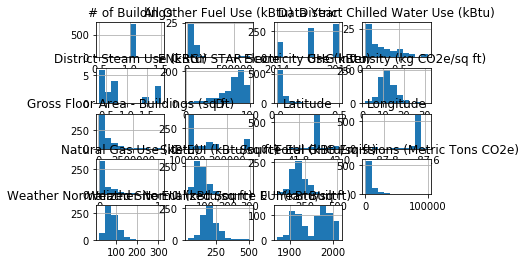

In [3]:
'''In order to use sklearn methods, everything must be in floats and we cannot have missing   values.
    So we change dtypes and drop samples where essential data is not available'''
offices['# of Buildings']=offices['# of Buildings'].astype(float)
offices=offices.dropna(subset=['ENERGY STAR Score','Weather Normalized Site EUI (kBtu/sq ft)','Total GHG Emissions (Metric Tons CO2e)'])
print(offices.count())




offices.hist()

In [4]:
var=offices.columns.tolist()
print((var))

['Data Year', 'ID', 'Property Name', 'Address', 'ZIP Code', 'Community Area', 'Primary Property Type', 'Gross Floor Area - Buildings (sq ft)', 'Year Built', '# of Buildings', 'ENERGY STAR Score', 'Electricity Use (kBtu)', 'Natural Gas Use (kBtu)', 'District Steam Use (kBtu)', 'District Chilled Water Use (kBtu)', 'All Other Fuel Use (kBtu)', 'Site EUI (kBtu/sq ft)', 'Source EUI (kBtu/sq ft)', 'Weather Normalized Site EUI (kBtu/sq ft)', 'Weather Normalized Source EUI (kBtu/sq ft)', 'Total GHG Emissions (Metric Tons CO2e)', 'GHG Intensity (kg CO2e/sq ft)', 'Latitude', 'Longitude', 'Location']


In [5]:
'''We assume that if there was no data reported for a particular fuel source, none was used. So we replace nans with zeroes
'''
offices[['Electricity Use (kBtu)', 'Natural Gas Use (kBtu)', 'District Steam Use (kBtu)', 'District Chilled Water Use (kBtu)', 'All Other Fuel Use (kBtu)']]=offices[['Electricity Use (kBtu)', 'Natural Gas Use (kBtu)', 'District Steam Use (kBtu)', 'District Chilled Water Use (kBtu)', 'All Other Fuel Use (kBtu)']].fillna(0)

print(offices.count())





Data Year                                     732
ID                                            732
Property Name                                 732
Address                                       732
ZIP Code                                      732
Community Area                                732
Primary Property Type                         732
Gross Floor Area - Buildings (sq ft)          732
Year Built                                    732
# of Buildings                                732
ENERGY STAR Score                             732
Electricity Use (kBtu)                        732
Natural Gas Use (kBtu)                        732
District Steam Use (kBtu)                     732
District Chilled Water Use (kBtu)             732
All Other Fuel Use (kBtu)                     732
Site EUI (kBtu/sq ft)                         732
Source EUI (kBtu/sq ft)                       732
Weather Normalized Site EUI (kBtu/sq ft)      732
Weather Normalized Source EUI (kBtu/sq ft)    732


In [6]:
'''We change Year Built to Age, as Age is a more informative number'''
py=2019
offices['Year Built']=py-offices['Year Built']
offices=offices.rename({'Year Built':'Age'},axis=1)

In [7]:
#assess  Mean Absolute error
def mae(pred,test):
    return np.sum(np.abs(pred-test))/len(test)

In [8]:
def rmse(pred,test):
    return np.sqrt(np.sum((pred-test)**2)/len(test))

In [9]:
'''We split our table into features and targets, and drop columns that do not provide information relevant to the energy
    star score. We also randomize our samples'''
target=offices['ENERGY STAR Score'].values
features=offices[['Gross Floor Area - Buildings (sq ft)', 'Age', '# of Buildings', 'Electricity Use (kBtu)', 'Natural Gas Use (kBtu)', 'District Steam Use (kBtu)', 'District Chilled Water Use (kBtu)', 'All Other Fuel Use (kBtu)',  'Weather Normalized Site EUI (kBtu/sq ft)', 'Weather Normalized Source EUI (kBtu/sq ft)', 'Total GHG Emissions (Metric Tons CO2e)', 'GHG Intensity (kg CO2e/sq ft)']].values
ind=np.random.shuffle(np.arange(0,target.shape[0]))

features[:,:]=features[ind,:]
target[:]=target[ind]

In [21]:
#We implement the k-fold cross-validation method from the course Data-Driven Astronomy, so that we can check each fold 
#individually for underfitting/overfitting
def cross_validate_model(model, features, targets, k):
  kf = sk.KFold(n_splits=k, shuffle=True)

  # declare an array for predicted redshifts from each iteration
  all_predictions = np.zeros_like(targets)

  for train_indices, test_indices in kf.split(features):
    
    # split the data into training and testing
    train_f,train_t=features[train_indices],targets[train_indices]
    test_f,test_t=features[test_indices],targets[test_indices]
    # fit the model for the current set
    model.fit(train_f,train_t)    
    # predict using the model
    predictions=model.predict(test_f)    
    predtr=model.predict(train_f)    
    
    #print('test err ',mae(predictions,test_t),'train err ',mae(predtr,train_t))
    # put the predicted values in the all_predictions array defined above
   

    all_predictions[test_indices] = predictions

  # return the predictions
  return all_predictions    


In [22]:
def testTreeDepth(depth,features,target):    
    tfrac=.5
    trainx=int(features.shape[0]*tfrac)
    trainf=features[trainx:,:]
    testf=features[:trainx,:]
    traint=target[trainx:]
    testt=target[:trainx]

    dtr=DecisionTreeRegressor(max_depth=depth)
    dtr.fit(trainf,traint)
    

    dot_data = export_graphviz(dtr, out_file=None,feature_names=['Gross Floor Area - Buildings (sq ft)', 'Age', '# of Buildings', 'Electricity Use (kBtu)', 'Natural Gas Use (kBtu)', 'District Steam Use (kBtu)', 'District Chilled Water Use (kBtu)', 'All Other Fuel Use (kBtu)',  'Weather Normalized Site EUI (kBtu/sq ft)', 'Weather Normalized Source EUI (kBtu/sq ft)', 'Total GHG Emissions (Metric Tons CO2e)', 'GHG Intensity (kg CO2e/sq ft)'])
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_pdf("decision_tree.pdf")


    predt=dtr.predict(testf)
    predtr=dtr.predict(trainf)
    print('train err',mae(predtr,traint),rmse(predtr,traint))

    print('test err',mae(predt,testt),rmse(predt,testt))
    return mae(predtr,traint),mae(predt,testt)

In [23]:
'''As a baseline, split into two equally sized sets, and perform a decision tree regression with
    a maximum depth of five layers'''
t=testTreeDepth(5,features,target)

train err 3.847326535252894 5.4344489907419895
test err 5.768742922474802 8.119731055793313


In [24]:
'''Appears to overfit'''

'Appears to overfit'

depth 1
train err 10.566975368801165 14.366930455795597
test err 10.020148777159976 13.097208055232457
depth 2
train err 8.355039806085273 10.888047231314882
test err 8.103126368694507 10.910112098157697
depth 3
train err 6.066065271091155 8.242098447196689
test err 6.627870220379598 9.612696484023635
depth 4
train err 4.987073262820611 6.8986239670101215
test err 6.185996464159435 9.143640019011768
depth 5
train err 3.847326535252894 5.4344489907419895
test err 5.734589917010322 8.097168633944722
depth 6
train err 3.0891148268461865 4.47592727997735
test err 5.819267378103091 8.614674903364563


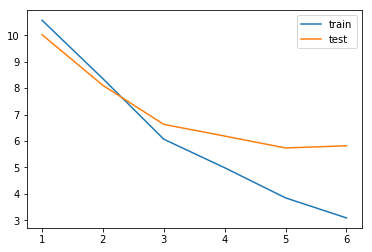

In [25]:
'''What happens if we vary the tree depth?'''
d=np.arange(1,7)
k=np.arange(3,20)
train=np.zeros(len(d))
test=np.zeros(len(d))

for i in d:
    print('depth',i)
    t=testTreeDepth(i,features,target)
    train[i-1]=t[0]
    test[i-1]=t[1]
#check if overfitting. Plot train error v test
a=plt.plot(d,train,label='train')
plt.plot(d,test,label='test')





plt.legend()
plt.show()

In [26]:
'''Wow, starts overfitting very quickly! We want comparable errors, so maybe depth=3 is best'''

'Wow, starts overfitting very quickly! We want comparable errors, so maybe depth=3 is best'

In [27]:
'''see if crossvalidation helps. Unfortunately, can no longer check overall overfitting'''
def testTreeDepth2(depth,features,target,kk):    


    dtr=DecisionTreeRegressor(max_depth=depth)
    pred=cross_validate_model(dtr,features,target,kk)
    
    print('test err',mae(pred,target),rmse(pred,target))
    return mae(pred,target)

test err 7.370688687944727 10.365288722039866
test err 6.9460722439003115 9.784655248791363
test err 7.295044865832025 10.08405577039149
test err 7.177330225914851 10.0230007800263
test err 6.884294561019148 9.34444872213584
test err 7.323685675854789 10.201932526327663
test err 7.056754403379033 9.684845805004837
test err 7.181592785477421 9.991289852000438
test err 7.314071077595428 10.096212061588416
test err 7.000800073180717 9.654872389290555
test err 7.236586813676851 10.006886977966312
test err 7.032105882242866 9.76280899386644
test err 6.889415880427185 9.63949420165002
test err 7.000972455067545 9.81701797542441
test err 7.10369244819864 9.94584431726555
test err 7.080769057281526 9.856123811452386
test err 7.024085523099402 9.791350572371547
test err 7.014614956020452 9.887663526143413
test err 6.818569848966264 9.463394457251205
test err 7.07343465982178 10.1206339256726
test err 6.945424678351069 9.706492006340493
test err 6.95875128493621 9.50763510037332
test err 6.93496

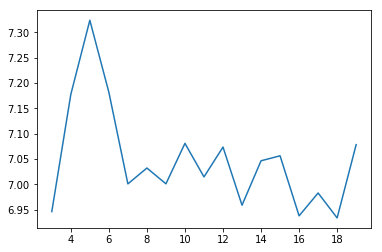

In [28]:
errs=np.zeros(len(k))
for kk in k:
    testTreeDepth2(3,features,target,kk)
    errs[kk-k[0]]=testTreeDepth2(3,features,target,kk)
   
plt.plot(k,errs)
plt.show()


In [ ]:
'''We get a different plot every time, but errors consistently between 6.9 and 7.4. Cross validation doesn't really help

In [ ]:
for i in d:
    testTreeDepth2(i,features,target,6)
#ch


In [32]:
'''Is random forest better?'''
rfr=RandomForestRegressor(n_estimators=1000,max_depth=3)
pred=cross_validate_model(rfr,features,target,5)
print(mae(pred,target))

6.185402320224465


In [ ]:
'''A little over 6. Better, a little. Considering the energy score is between 0 and 100, like 6% error'''